In [54]:
import solr
import urllib
import json
import spacy
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns

## Load the data

In [2]:
data = open('yfcc100m_videos_metadata.csv').readlines()
print 'Num Samples:', len(data)

Num Samples: 793436


- 0: id
- 2: userid
- 3: DT
- 6: title
- 7: description
- 8: tags
- 14: url

In [3]:
def url_decode(in_str):
    return urllib.unquote(in_str).decode('utf8').replace('+',' ')

def filter_list(target, indices):
    return [target[i] for i in indices]

In [4]:
ids, users, dts, titles, descs, tags, urls = [],[],[],[],[],[],[]
for sample in data:
    sample = sample.split('\t')
    ids.append(sample[0])
    users.append(sample[2])
    dts.append(sample[3])
    titles.append(url_decode(sample[6]))
    descs.append(url_decode(sample[7]))
    tags.append(sample[8])
    urls.append(sample[14])

## Select the samples that have a description

In [5]:
non_empty_desc_idx = [i for i in range(len(data)) if len(descs[i])>0]
print len(non_empty_desc_idx)

237853


In [6]:
ids = filter_list(ids, non_empty_desc_idx)
users = filter_list(users, non_empty_desc_idx)
dts = filter_list(dts, non_empty_desc_idx)
titles = filter_list(titles, non_empty_desc_idx)
descs = filter_list(descs, non_empty_desc_idx)
tags = filter_list(tags, non_empty_desc_idx)
urls = filter_list(urls, non_empty_desc_idx)

print len(ids), len(users), len(dts), len(titles), len(descs), len(tags), len(urls)

237853 237853 237853 237853 237853 237853 237853


In [9]:
# list of user ids in corpus
users_list = list(set(users))
print 'There are',len(users_list),'total users in the corpus'

users_idx = {}
idx = 0
for u in users:
    if u not in users_idx:
        users_idx[u]=idx
        idx += 1

userids = [users_idx[u] for u in users]

36034


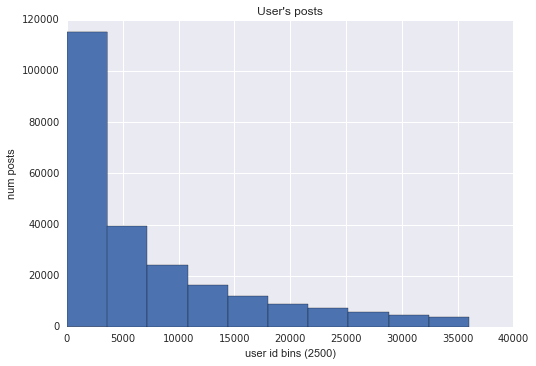

In [14]:
plt.hist(userids)
plt.title("User's posts")
plt.xlabel('user id bins (2500)')
plt.ylabel('num posts')
plt.show()

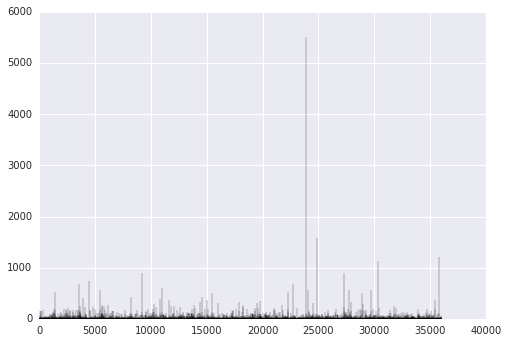

In [33]:
user_post_count = {}
for u in users:
    if u not in user_post_count:
        user_post_count[u] = 1
    else:
        user_post_count[u] += 1

user_post_count = [(u,c) for u, c in user_post_count.iteritems()]
sorted(user_post_count, key=lambda x:x[1], reverse=True)
plt.bar(xrange(len(user_post_count)),zip(*user_post_count)[1])
plt.show()

## Select the users with more posts

In [39]:
user_post_count = sorted(user_post_count, key=lambda x:x[1], reverse=True)
print '\n'.join(['{:<50} {}'.format(u,c) for u,c in user_post_count[:30]])
print '{:<50} {}'.format('Total Videos', sum(zip(*user_post_count[:30])[1]))

Baha%27i+Views+%2F+Flitzy+Phoebie                  5514
Joe+Shlabotnik                                     1587
Arthur+Chapman                                     1204
labanex                                            1130
Diamond+Geyser                                     901
David+Gallagher                                    899
BrentDPayne                                        744
Tobyotter                                          690
Manchester+Peregrines                              675
Timo_Beil                                          595
marymactavish                                      570
Rev.+Xanatos+Satanicos+Bombasticos+%28ClintJCL%29  566
Travis+S.                                          560
Jo+%26+Joey                                        560
jencu                                              528
MiNe+%28sfmine79%29                                520
waltarrrrr                                         506
Andy+E.+Nystrom                                    504
jasone

In [38]:
top_users = zip(*user_post_count[:30])[0]

In [40]:
# this list has the index of target videos
top_users_idx = [i for i in xrange(len(users)) if users[i] in top_users]

In [41]:
top_ids = filter_list(ids, top_users_idx)
top_users = filter_list(users, top_users_idx)
top_dts = filter_list(dts, top_users_idx)
top_titles = filter_list(titles, top_users_idx)
top_descs = filter_list(descs, top_users_idx)
top_tags = filter_list(tags, top_users_idx)
top_urls = filter_list(urls, top_users_idx)

In [48]:
top_descs_lens = [len(top_descs[i]) for i in xrange(len(top_descs))]
print 'Descriptions lengths'
print 'max:', max(top_descs_lens)
print 'min:', min(top_descs_lens)
print 'mean:', np.mean(top_descs_lens)
print 'std:', np.std(top_descs_lens)

Descriptions lengths
max: 7615
min: 1
mean: 167.324874217
std: 340.920566703


## Import into solr

In [58]:
solr_flickr_url = 'http://holbox.lti.cs.cmu.edu:8983/solr/flickr'
solr_flickr = solr.SolrConnection(solr_expertv_url)

In [59]:
# Load the spacy pipeline
nlp = spacy.load('en')

In [60]:
for i in xrange(len(top_ids)):
    solr_flickr.add(id=top_ids[i],
                    user=top_users[i],
                    datetime=top_dts[i],
                    title=top_titles[i],
                    desc=top_descs[i],
                    tags=top_tags[i],
                    ulr=top_urls[i])
solr_flickr.commit()

'<?xml version="1.0" encoding="UTF-8"?>\n<response>\n<lst name="responseHeader"><int name="status">0</int><int name="QTime">960</int></lst>\n</response>\n'

In [72]:
query = 'youtube'

response = solr_flickr.query('desc:"%s"~1'%(query))
print list(response)
for r in response:
    print r['desc'][0]

[]
